In [1]:
import os, subprocess
import json
import uproot3
import awkward as ak
import numpy as np
from coffea import processor, util, hist

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
with open('xsec.json') as f:
  xs = json.load(f)

with open('pmap_hbb.json') as f:
  pmap = json.load(f)

In [3]:
lumis = {}
lumis['2016'] = 35.9
lumis['2017'] = 41.5
lumis['2018'] = 59.2

year='2017'

In [5]:
indir = "outfiles/notrigger/chunksize100000/"
infiles = subprocess.getoutput("ls "+indir+year+"*.coffea").split()
outsum = processor.dict_accumulator()

# Check if pickle exists, remove it if it does                                                                             
picklename = str(year)+'/templates.pkl'
if os.path.isfile(picklename):
    os.remove(picklename)
    
started = 0
for filename in infiles:

    print("Loading "+filename)

    if os.path.isfile(filename):
        out = util.load(filename)

        if started == 0:
            outsum['templates'] = out['templates']
            outsum['sumw'] = out['sumw']
            started += 1
        else:
            outsum['templates'].add(out['templates'])
            outsum['sumw'].add(out['sumw'])
    
        del out

Loading outfiles/notrigger/chunksize100000/2017_dask_data.coffea
Loading outfiles/notrigger/chunksize100000/2017_dask_higgs.coffea
Loading outfiles/notrigger/chunksize100000/2017_dask_qcd.coffea
Loading outfiles/notrigger/chunksize100000/2017_dask_top.coffea
Loading outfiles/notrigger/chunksize100000/2017_dask_wandvv.coffea
Loading outfiles/notrigger/chunksize100000/2017_dask_z.coffea


In [6]:
scale_lumi = {k: xs[k] * 1000 *lumis[year] / w for k, w in outsum['sumw'].items()}
outsum['templates'].scale(scale_lumi, 'dataset')

templates = outsum['templates'].group('dataset', hist.Cat('process', 'Process'), pmap)

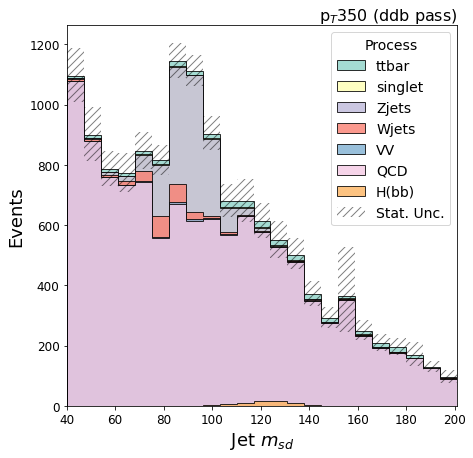

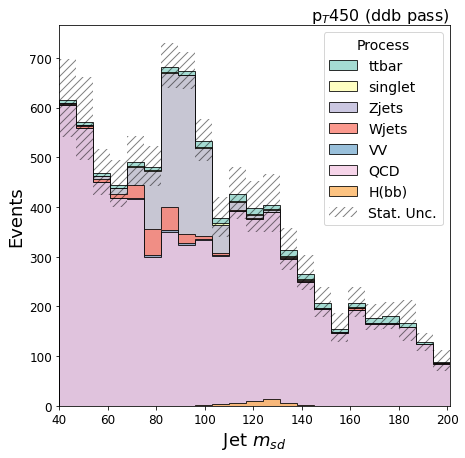

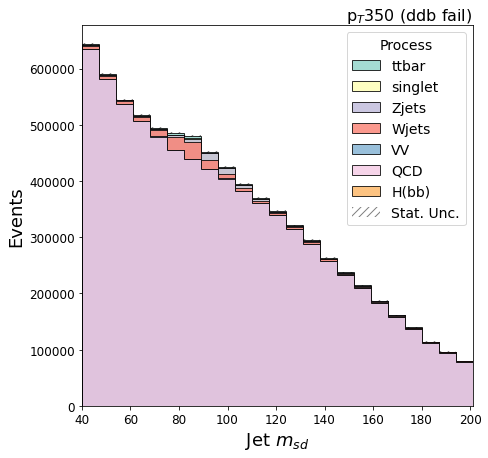

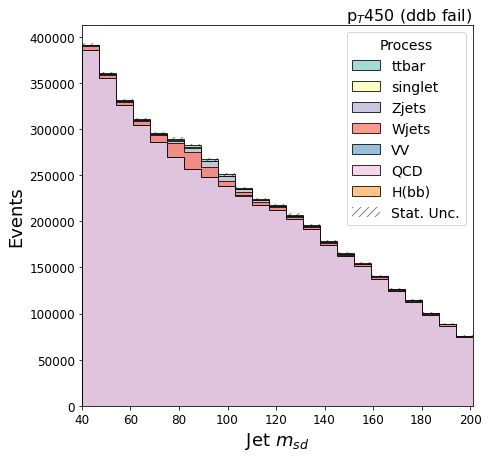

In [29]:
ddb_regions = ['pass', 'fail']
pt_regions = [350, 450]

for ddb_region in ddb_regions:
    for pt_region in pt_regions:
        
        if ddb_region == 'pass':
            ddb_l = 0.64
            ddb_r = 1
        elif ddb_region == 'fail':
            ddb_l = 0
            ddb_r = 0.64 

        h_QCD = templates['QCD'].integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(pt_region,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))
        h_hbb = templates['H(bb)'].integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(pt_region,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))
        h_VV = templates['VV'].integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(pt_region,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))
        h_Wjets = templates['Wjets'].integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(pt_region,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))
        h_Zjets = templates['Zjets'].integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(pt_region,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))
        h_singlet = templates['singlet'].integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(pt_region,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))
        h_ttbar = templates['ttbar'].integrate('region','signal').sum('genflavor').integrate('pt1',int_range=slice(pt_region,1200)).integrate('ddb1',int_range=slice(ddb_l,ddb_r))

        #scale_process = {t[0]: -1 for t in templates.values().keys() if t[1] == 'signal'}

        #h_pt450.scale(scale_process, 'process')

        #h_diff = h_pt350.add(h_pt450)

          # make a nice ratio plot, adjusting some font sizes
        plt.rcParams.update({
                'font.size': 14,
                'axes.titlesize': 18,
                'axes.labelsize': 18,
                'xtick.labelsize': 12,
                'ytick.labelsize': 12
            })
        fig, (ax) = plt.subplots(
            nrows=1,
            ncols=1,
            figsize=(7,7),
            #gridspec_kw={"height_ratios": (3, 1)},
            sharex=True
        )
        fig.subplots_adjust(hspace=.07)

        # Here is an example of setting up a color cycler to color the various fill patches
        # We get the colors from this useful utility: http://colorbrewer2.org/#type=qualitative&scheme=Paired&n=6
        from cycler import cycler
        #colors = ['#e31a1c','#ffffb3','#a6bbe3','#1f78b4','#b2df8a','#33a02c','#fb9a99']
        colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#80b1d3','#f4cae4','#fdb462']
        ax.set_prop_cycle(cycler(color=colors))

        fill_opts = {
            'edgecolor': (0,0,0,0.3),
            'alpha': 0.8
        }
        error_opts = {
            'label': 'Stat. Unc.',
            'hatch': '///',
            'facecolor': 'none',
            'edgecolor': (0,0,0,.5),
            'linewidth': 0
        }
        data_err_opts = {
            'linestyle': 'none',
            'marker': '.',
            'markersize': 10.,
            'color': 'k',
            'elinewidth': 1,
        }

        hist.plot1d(
                h_QCD.add(h_VV).add(h_Wjets).add(h_Zjets).add(h_ttbar).add(h_singlet).add(h_hbb),
                overlay="process",
                ax=ax,
                clear=False,
                stack=True,
                line_opts=None,
                fill_opts=fill_opts,
                error_opts=error_opts
            )

        ddb = plt.text(1., 1., r'p$_{T}$' + str(pt_region) + ' (ddb ' + ddb_region + ')',
                            fontsize=16,
                            horizontalalignment='right',
                            verticalalignment='bottom',
                            transform=ax.transAxes
                           )

        fig.savefig('plots/' + 'mc_pT' + str(pt_region) + "_" + ddb_region + '.png')